# Inference

Overview of how to use the trained models from release v.0.3 in a real world application.

The data is currently not available but the pretrained models are available in the at the Dropbox link shared in the `README.md` file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import statannot
import utils

sns.set(context='talk', font='Arial', style='whitegrid', palette='muted')
sns.set_style("ticks", {"xtick.major.size": 0, "ytick.major.size": 0})

### Analysis – Nuclei

Once the models and images to segment nuclei are imported, we can begin to compare a select few metrics commonly used for segmentation. Afterwards, we predict all test images and calculate the metric of choice (here AUC). Finally, we visualize predicted segmentation maps.

#### Import

In [3]:
model_binary = tf.keras.models.load_model('../models/v0.3_Binary_Nucleus.h5')
model_categorical = tf.keras.models.load_model('../models/v0.3_Categorical_Nucleus.h5')

In [4]:
DIR_IMAGES = '../data/test/images/'
DIR_MASKS = '../data/test/masks/'

files_images = sorted(glob.glob(f'{DIR_IMAGES}/*.tif'))
files_masks = sorted(glob.glob(f'{DIR_MASKS}/*.tif'))

images = list(map(skimage.io.imread, files_images))
masks = list(map(skimage.io.imread, files_masks))

images_adapt = []
masks_adapt = []

# Prevents problem with one dataset having 1px differences
for i, m in zip(images, masks):
    if m.shape != i.shape:
        dim0 = min(i.shape[0], m.shape[0])
        dim1 = min(i.shape[1], m.shape[1])
        images_adapt.append(i[:dim0, :dim1])
        masks_adapt.append(m[:dim0, :dim1])
    else:
        images_adapt.append(i)
        masks_adapt.append(m)
        
images = images_adapt
masks = masks_adapt

#### Metric comparison

In [5]:
utils.compare_methods(images[0], masks[0], model_binary, model_categorical)

–––––––––––
Otsu
Accuracy: 0.952667236328125
AUC: 0.8380837440490723
MSE: 0.047332763671875
IOU: 0.8062999844551086
–––––––––––
Binary
Accuracy: 0.929473876953125
AUC: 0.9435907006263733
MSE: 0.06744222342967987
IOU: 0.7860999703407288
–––––––––––
Categorical
Accuracy: 0.935211181640625
AUC: 0.7730698585510254
MSE: 0.05177118256688118
IOU: 0.7346000075340271


#### Visualization

In [6]:
def metric_summary(images, masks, metric=utils.evaluate_auc):
    val_otsu, val_binary, val_categorical = [], [], []
    
    for image, mask in zip(images, masks):
        val_otsu.append(metric(mask, utils.predict_otsu(image)))
        val_binary.append(metric(mask, utils.predict_binary(image, model_binary)))
        val_categorical.append(metric(mask, utils.predict_categorical(image, model_categorical)))
    
    return val_otsu, val_binary, val_categorical

val_otsu, val_binary, val_categorical = metric_summary(images, masks)

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

otsu v.s. binary: t-test independent samples, P_val=3.155e-04 stat=-3.751e+00


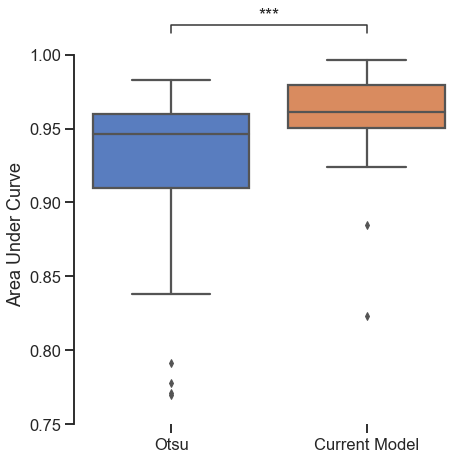

In [7]:
current_model = 'binary'

# Define DataFrame
df = pd.DataFrame()
df['otsu'] = val_otsu
df['binary'] = val_binary
df['categorical'] = val_categorical
df = pd.melt(df, var_name='method', value_name='values')
df_plot = df[(df['method'] == 'otsu') | (df['method'] == current_model)]

# Plotting
fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.boxplot(x='method', y='values', data=df_plot)
statannot.add_stat_annotation(ax, data=df_plot,
                              x='method', y='values',
                              box_pairs=[(('otsu'), (current_model))],
                              test='t-test_ind', loc='outside', verbose=1, stack=False)

# Styling
ax.set_xlabel('')
ax.set_xticklabels(['Otsu', 'Current Model'])
ax.set_ylim(0.75)
ax.set_ylabel('Area Under Curve')
sns.despine(left=False, bottom=True, trim=True)

# plt.savefig('auc.pdf', bbox_inches='tight')
plt.show()

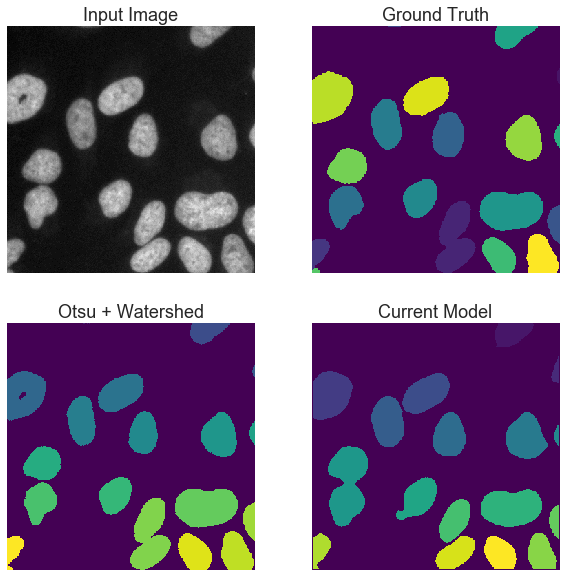

In [8]:
cmap = 'viridis'

def visualize_evaluation(image, mask):
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].set_title('Input Image')
    ax[0, 0].imshow(image, cmap='gray')
    ax[0, 0].axis('off')
    ax[0, 1].set_title('Ground Truth')
    ax[0, 1].imshow(mask, cmap=cmap)
    ax[0, 1].axis('off')
    ax[1, 0].set_title('Otsu + Watershed')
    ax[1, 0].imshow(utils.predict_otsu(image, add_instances=True), cmap=cmap)
    ax[1, 0].axis('off')
    ax[1, 1].set_title('Current Model')
    ax[1, 1].imshow(utils.predict_categorical(image, model_categorical, add_instances=True), cmap=cmap)
    ax[1, 1].axis('off')
    
#     plt.savefig('example_nuclei.pdf', bbox_inches='tight')
    plt.show()

i = 5
visualize_evaluation(images[i], masks[i])

#### Error analysis

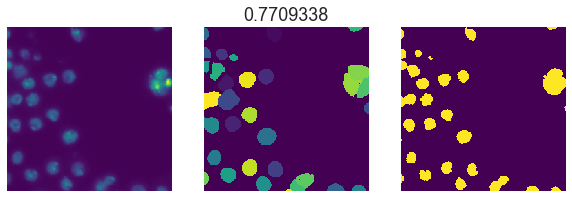

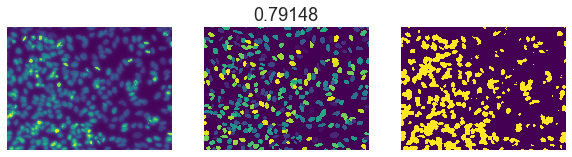

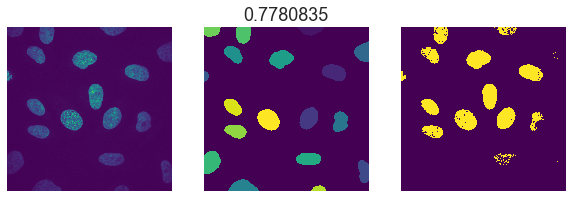

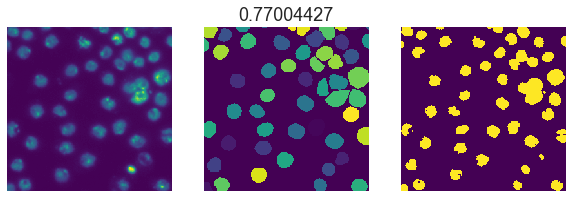

In [9]:
cmap = 'viridis'

def display_below_cutoff(lst, cutoff):

    for n, i in enumerate(lst):
        if i < cutoff:
            fig, ax = plt.subplots(1, 3, figsize=(10, 5))
            ax[0].imshow(images[n], cmap=cmap)
            ax[0].axis('off')
            ax[1].set_title(i)
            ax[1].imshow(masks[n], cmap=cmap)
            ax[1].axis('off')
            ax[2].imshow(utils.predict_otsu(images[n]), cmap=cmap)
    #         ax[2].imshow(utils.predict_binary(images[n]), cmap=cmap)
    #         ax[2].imshow(utils.predict_categorical(images[n]), cmap=cmap)
            ax[2].axis('off')
            plt.show()

display_below_cutoff(val_otsu, 0.8)

### Analysis – Granules

Granules have a slightly different functionality due to their binary nature. Here, they are only imported and visualized using the same prediciton function used for binary nucleus segmentation.

#### Import

In [10]:
model_granule = tf.keras.models.load_model('../models/v0.3_Binary_Granules.h5')

In [11]:
DIR_IMAGES = '../data/granules/images/'
DIR_MASKS = '../data/granules/masks/'

files_images = sorted(glob.glob(f'{DIR_IMAGES}/*.tif'))
files_masks = sorted(glob.glob(f'{DIR_MASKS}/*.tif'))

images = list(map(skimage.io.imread, files_images))
masks = list(map(skimage.io.imread, files_masks))

#### Visualization

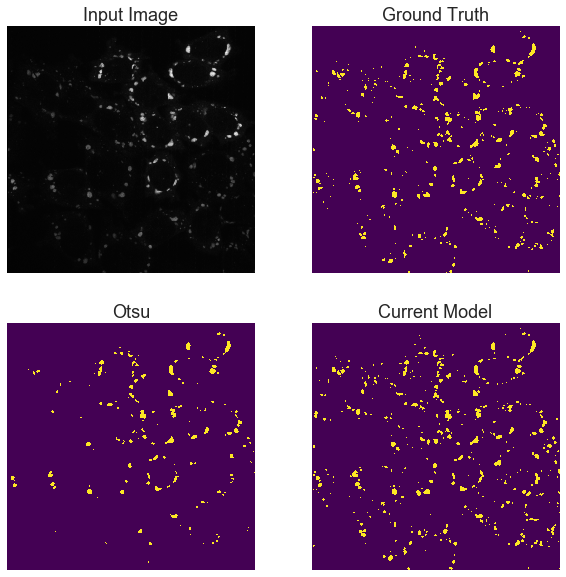

In [12]:
cmap = 'viridis'

def visualize_evaluation(image, mask):
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].set_title('Input Image')
    ax[0, 0].imshow(image, cmap='gray')
    ax[0, 0].axis('off')
    ax[0, 1].set_title('Ground Truth')
    ax[0, 1].imshow(mask > 0, cmap=cmap)
    ax[0, 1].axis('off')
    ax[1, 0].set_title('Otsu')
    ax[1, 0].imshow(utils.predict_otsu(image), cmap=cmap)
    ax[1, 0].axis('off')
    ax[1, 1].set_title('Current Model')
    ax[1, 1].imshow(utils.predict_binary(image, model=model_granule) > 0.5, cmap=cmap)
    ax[1, 1].axis('off')
    
#     plt.savefig('example_granules.pdf', bbox_inches='tight')
    plt.show()

i = 0
visualize_evaluation(images[i], masks[i])